In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget

import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, IntSlider, Layout, interact_manual, fixed
import ipywidgets as widgets
from IPython.display import display
import h5py
from glob import glob
import numpy as np
from csbdeep.utils import Path, normalize
from tqdm import tqdm
import stardistwrapper as sdw
from trackers import *

# 3D Tracking using 3D Instance segmentation + 2D tracking + combining

Combine Best instance segmentation (WaterZ) + 2D tracker to track in 3D
- 1. Do instance segmentation
- 2. Process slices instances for 2D tracking (Erosion)
- 3. Generate tracks for instances in 2D
- 4. Combine 3D instances with 2D tracks 

Different 2D+T trackers can be used in Step2 

## Load data

In [7]:
import h5py

path = 'data/GT/'
f = h5py.File(path+'GT_TrackID.h5','r+') # Track file
gt_track = f['image'][:]
f.close()

f = h5py.File(path+'Plantseg_T29-39.h5','r+') # PlantSeg file
plantseg = f['image'][:]
f.close()

## Instance segmentation
Using WaterZ, as that has shown be have highest accuracy

In [3]:
max_t, max_z, *_ = plantseg.shape
kernel = np.ones((1, 3, 3), np.uint8) # Erode Z,Y,X

predicted_fragments = np.zeros(plantseg.shape)
eroded_fragments = np.zeros(plantseg.shape)
for t in range(max_t):
    _f = get_fragments(plantseg[t], 0.55)
    
    _f2 = np.zeros(_f.shape, dtype=np.int64)
    
    # Erode X,Y axis
    for g in np.unique(_f):
        _mask = mask(_f, g)
        _mask2 = ndimage.binary_erosion(_mask, structure=kernel)
        _f2 = _f2 + _mask2*g
    
    predicted_fragments[t] = _f
    eroded_fragments[t] = _f2

Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 484 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 2159
merging until threshold 0.55
computing initial scores
merging until 0.55
min edge score 0.0129592
threshold exceeded
merged 285 edges
extracting segmentation
Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 433 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 1895
merging until threshold 0.55
computing initial scores
merging until 0.55
min edge score 0.0478849
threshold exceeded
merged 249 edges
extracting segmentation
Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 460 nodes
creating statistics provider
extracting region graph...
Region graph number of edg

### Prepare for 2D tracking
Transform to Z,T,Y,X

In [6]:
binary_z_slices = np.where(eroded_fragments.transpose((1,0,2,3)) > 0, 1, 0) 
binary_z_slices = normalize(binary_z_slices, 1, 99.8)

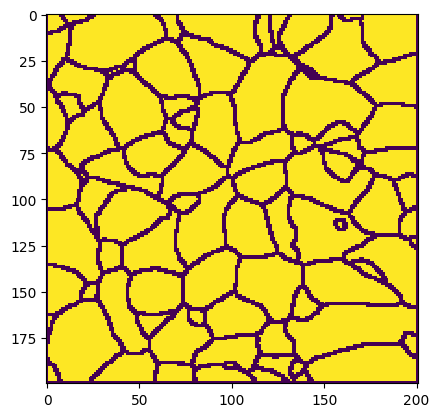

In [5]:
plt.figure()
plt.imshow(binary_z_slices[10,0])
plt.show()

## Track 2D slices

In [8]:
model_name="fatepredict_temporal_model1"
model = sdw.load_stardist_model(model_name=model_name)

2023-12-03 18:34:12.482610: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-03 18:34:12.522239: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-03 18:34:12.525280: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.
Load pretrained stardist model 'fatepredict_temporal_model1' from folder 'stardist_models'


In [9]:
freq = 5
predicted_tracks = np.zeros(binary_z_slices.shape)
predicted_tracks_i = []
for i in range(max_z):
    if i%freq == 0:
        predicted_tracks[i] = model.predict_instances(binary_z_slices[i], show_tile_progress=False)[0][0]
        predicted_tracks_i.append(i)

2023-12-03 18:34:24.214931: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8900


1/1 [==============================] - 0s 24ms/step



Qhull output at end
qhull precision warning: 
The initial hull is narrow (cosine of min. angle is 0.9999999999999991).
Is the input lower dimensional (e.g., on a plane in 3-d)?  Qhull may
produce a wide facet.  Options 'QbB' (scale to unit box) or 'Qbb' (scale
last coordinate) may remove this warning.  Use 'Pp' to skip this warning.
See 'Limitations' in qh-impre.htm.


1/1 [==============================] - 0s 24ms/step


### Pickle

#### Save

In [16]:
import pickle
pickle.dump({
    'predicted_fragments': predicted_fragments,
    'eroded_fragments': eroded_fragments,
    'binary_z_slices': binary_z_slices,
    'predicted_tracks': predicted_tracks,
    'predicted_tracks_i': predicted_tracks_i
}, open( '5_multiplane_track1_waterz_stardist.pkl', 'wb' ) )

#### Load

In [4]:
import pickle
pkl = pickle.load(open('5_multiplane_track1_waterz_stardist.pkl', 'rb'))
predicted_fragments = pkl['predicted_fragments']
eroded_fragments = pkl['eroded_fragments']
binary_z_slices = pkl['binary_z_slices']
predicted_tracks = pkl['predicted_tracks']
predicted_tracks_i = pkl['predicted_tracks_i']
predicted_tracks_orig = deepcopy(predicted_tracks)

## Visualize tracks

In [57]:
import napari

#filter = (Y[0]==39) | (Y[0]==34) | (Y[0]==29) | (Y[0]==25)
viewer = napari.Viewer()
#viewer.add_labels(Y[0]*filter, name='Labels')
viewer.add_image(binary_z_slices[0].astype(int), name='Cells')
viewer.add_labels(predicted_tracks[0].astype(int), name='Tracks')

<Labels layer 'Tracks' at 0x2cbff0580>

## Combine

In [5]:
from skimage.measure import regionprops

def pick_match(c,z,t):
    y,x = (int(centroid[0]), int(centroid[1]))
    return predicted_fragments[t,z,y,x].astype(int)

track_id_fragment = {}
matching_fragments = []
for z in predicted_tracks_i:
    _tracks = predicted_tracks[z].astype(int)
    _max_t, *_ = _tracks.shape
    
    track_ids = np.unique(_tracks)
    track_ids = track_ids[track_ids != 0].astype(int)

    for t in range(_max_t):
        #print('t:',t)

        _matching_fragments = {}
        for tr_id in track_ids:
            track = _tracks[t] == tr_id
            
            if np.sum(track)>0:
                #print('- tr_id:', tr_id)
                centroid = regionprops(track.astype(int))[0].centroid
                f = pick_match(centroid, z, t)

                if tr_id2:=_matching_fragments.get(f):
                    # Merge current track with matched track (tr_id2)
                    _tracks[_tracks == tr_id] = tr_id2
                    #print('replacing %s with %s' % (tr_id, tr_id2))
                else:
                    _matching_fragments[f] = tr_id
                    
        matching_fragments.append(_matching_fragments)
        predicted_tracks[z] = _tracks

# assign
for i,z in enumerate(predicted_tracks_i):
    _matching_fragments = matching_fragments[i]
    

## Visualize merged tracks

In [48]:
import napari
viewer = napari.Viewer()

viewer.add_labels(gt_track[:, 5], name='GroundTruth')
viewer.add_labels(predicted_tracks_orig[0].astype(int), name='StarDist Prediction')
viewer.add_labels(predicted_tracks[0].astype(int), name='StarDist Prediction Merged')

<Labels layer 'StarDist Prediction Merged' at 0x298d3d5b0>

## Metrics on merged tracks

In [10]:
from trackers import evaluate_hota

metrics1, hota = evaluate_hota(gt_track[:, 5, :, :], predicted_tracks_orig[5])
metrics2, hota = evaluate_hota(gt_track[:, 5, :, :], predicted_tracks[5])

In [11]:
print('%.3f' % metrics2['AssA'][9])
print('%.3f' % metrics2['AssA'][17])
print('%.3f' % metrics2['DetA'][9])
print('%.3f' % metrics2['DetA'][17])
print('%.3f' % metrics2['LocA'][9])
print('%.3f' % metrics2['LocA'][17])
print('%.3f' % metrics2['HOTA'][9])
print('%.3f' % metrics2['HOTA'][17])
print('H@0.75: %.3f' % metrics2['HOTA'][14])

0.646
0.000
0.284
0.000
0.700
1.000
0.428
0.000
H@0.75: 0.183


## Pickle all metrics

In [12]:
import pickle
pickle.dump({
    'stardist_track': metrics1,
    'stardist_track_merged': metrics2,
    'array_labels': hota.array_labels
}, open( '5_all_metrics.pkl', 'wb' ) )